In [1]:
# imports
from keras.models import Model
from keras.layers import Input, Dense, Lambda
from keras import backend as K
from keras import objectives
from scipy.stats import norm
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


In [2]:
# set hyperparams
batch_size = 100
original_dimension = 28 * 28 # height x width of MNIST image
latent_dimension = 2
intermediate_dimension = 256
num_epoch = 5
epsilon_std = 1.0

## Create the Encoder

In [3]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon= K.random_normal(shape=(batch_size, latent_dimension), mean=0)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [4]:
x = Input(shape=(original_dimension,), name="input") # encoder input
h = Dense(intermediate_dimension, activation="relu", name="encoding")(x) # intermediate layer
z_mean = Dense(latent_dimension, name="mean")(h) # mean of latent space
z_log_var = Dense(latent_dimension, name="log-variance")(h) # log variance of latent space
z = Lambda(sampling, output_shape=(latent_dimension,))([z_mean, z_log_var])

encoder = Model(x, [z_mean, z_log_var, z], name="encoder")

2022-03-19 20:57:00.329306: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-19 20:57:00.329807: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


## Create the Decoder

In [5]:
input_decoder = Input(shape=(latent_dimension,), name="decoder_input") # decoder input
decoder_h = Dense(intermediate_dimension, activation="relu", name="decoder_h")(input_decoder) # intermediate layer
x_decoded = Dense(original_dimension, activation="sigmoid", name="flat_decoded")(decoder_h) # mean of original dimension

decoder = Model(input_decoder, x_decoded, name="decoder")

## Combining the model

In [6]:
output_combined = decoder(encoder(x)[2]) # get sampling z
variable_autoencoder = Model(x, output_combined)
variable_autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 784)               0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 201988    
_________________________________________________________________
decoder (Model)              (None, 784)               202256    
Total params: 404,244
Trainable params: 404,244
Non-trainable params: 0
_________________________________________________________________


## Defining loss function

In [7]:
def vae_loss(x, x_decoded_mean, original_dim=original_dimension):
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss
variable_autoencoder.compile(optimizer='rmsprop', loss=vae_loss)

## Split MNIST dataset

In [8]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

## Train the Model

In [9]:
variable_autoencoder.fit(x_train, x_train, shuffle=True, nb_epoch=num_epoch, batch_size=batch_size, validation_data=(x_test, x_test), verbose=1)

/Volumes/Samsung_T5/Apps/Anaconda/anaconda3/envs/deep-learning/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 12s 206us/step - loss: 191.4576 - val_loss: 172.8034
Epoch 2/5
60000/60000 [==============================] - 12s 195us/step - loss: 171.4407 - val_loss: 168.5247
Epoch 3/5
60000/60000 [==============================] - 12s 201us/step - loss: 167.0212 - val_loss: 165.5217
Epoch 4/5
60000/60000 [==============================] - 13s 210us/step - loss: 164.1956 - val_loss: 163.3754
Epoch 5/5
60000/60000 [==============================] - 13s 217us/step - loss: 162.2704 - val_loss: 161.8414


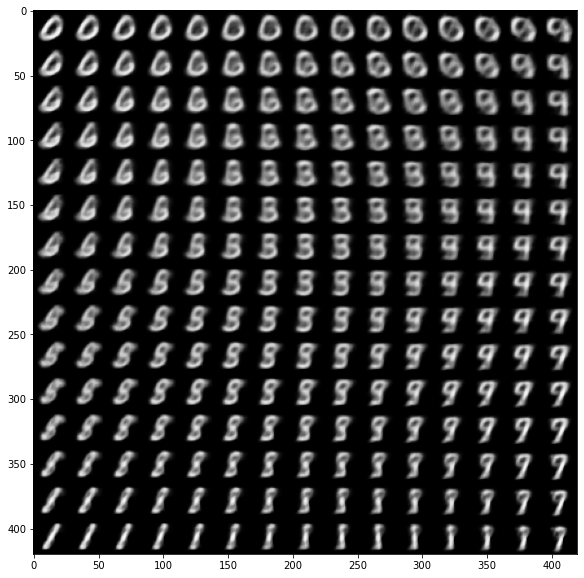

In [10]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()